# Drought Prediction in the Mediterranean

In [1]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, plot_confusion_matrix
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
%matplotlib inline
import numpy as np
import pandas as pd
import pickle

In [2]:
# Train/Test Split - Just run once
X_tas = np.load('Data/tas_train.npy')
X_psl = np.load('Data/psl_train.npy')
X_hf = np.load('Data/heatflux_train.npy')
y=np.load('Data/nao_index_train.npy')

X = np.concatenate((X_tas, X_psl, X_hf),axis=1)
y=y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

np.save('Data/train/X_train_wHF.npy', X_train)
np.save('Data/test/X_test_wHF.npy', X_test)
np.save('Data/train/y_train_wHF.npy', y_train)
np.save('Data/test/y_test_wHF.npy', y_test)

# Exploratory Data Analysis

In [3]:
#Load training data
X_train = np.load('Data/train/X_train_wHF.npy')
y_train = np.load('Data/train/y_train_wHF.npy')
print(X_train.shape)
print(y_train.shape)

(720, 6966)
(720, 1)


In [4]:
# Data are standardized by column
X_df = pd.DataFrame(X_train)
print("Range of means: ",X_df.mean().max() - X_df.mean().min())
print("Range of stdevs: ",X_df.std().max() - X_df.std().min())

Range of means:  0.11358084917841821
Range of stdevs:  0.10109558691530329


In [5]:
# No missing data (synthetic dataset, so none are expected)
X_df.isna().sum().sum()

0

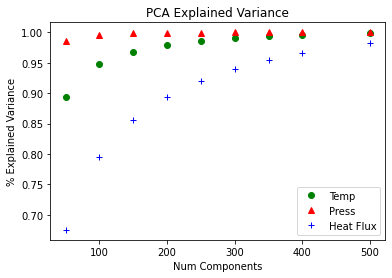

In [6]:
# PCA - Virtually all variance is explained in the first 200 PCs of press and the first 500 PCs of temp
num_components = [50,100,150,200,250,300,350,400,500]
explained_variance_temp = []
explained_variance_press = []
explained_variance_flux = []
for i in num_components:
    pca_temp = PCA(n_components=i)
    pca_press = PCA(n_components=i)
    pca_flux = PCA(n_components=i)
    X_tas_pca = pca_temp.fit_transform(X_train[:,0:2322])
    X_psl_pca = pca_press.fit_transform(X_train[:,2322:4645])
    X_hf_pca = pca_flux.fit_transform(X_train[:,4645:])
    explained_variance_temp.append(pca_temp.explained_variance_ratio_.sum())
    explained_variance_press.append(pca_press.explained_variance_ratio_.sum())
    explained_variance_flux.append(pca_flux.explained_variance_ratio_.sum())

    
plt.plot(num_components,explained_variance_temp,'go',label="Temp")
plt.plot(num_components,explained_variance_press,"r^",label="Press")
plt.plot(num_components,explained_variance_flux,"b+",label="Heat Flux")
plt.title("PCA Explained Variance")
plt.xlabel("Num Components")
plt.ylabel("% Explained Variance")
plt.legend(loc="lower right")
plt.show()


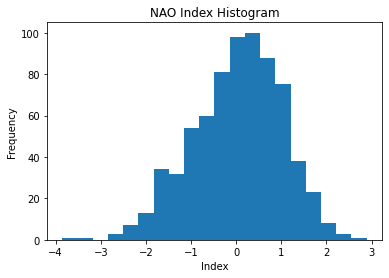

In [7]:
np.histogram(y_train, bins=20);
plt.title("NAO Index Histogram")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.hist(y_train,bins=20)
plt.show()

#### Investigate Correlation between target variable and each coordinate

In [8]:
data = pd.DataFrame(X_train)

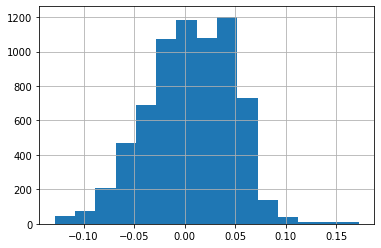

In [9]:
data.corrwith(pd.Series(y_train.reshape(720,))).hist(bins=15);

# Preprocessing

In [10]:
# Transform Training Data with PCA (~95% cutoff)
pca_temp = PCA(n_components=125)
pca_press = PCA(n_components=50)
pca_flux = PCA(n_components=350)
# After feedback from Eduardo Zorita, reduced the number of PCs.
# pca_temp = PCA(n_components=15)
# pca_press = PCA(n_components=15)

X_tas_pca = pca_temp.fit_transform(X_train[:,0:2322])
X_psl_pca = pca_press.fit_transform(X_train[:,2322:4645])
X_hf_pca = pca_flux.fit_transform(X_train[:,4645:])
X_train_pca = np.concatenate((X_tas_pca,X_psl_pca,X_hf_pca),axis=1)

In [11]:
# Calculate reconstruction error
X_tas_projected = pca_temp.inverse_transform(X_tas_pca)
X_psl_projected = pca_press.inverse_transform(X_psl_pca)
X_hf_projected = pca_flux.inverse_transform(X_hf_pca)
loss_temp = ((X_train[:,0:2322]-X_tas_projected)**2).mean()
loss_press = ((X_train[:,2322:4645]-X_psl_projected)**2).mean()
loss_hf = ((X_train[:,4645:]-X_hf_projected)**2).mean()
print('MSE Temp: '+str(loss_temp))
print('MSE Press: '+str(loss_press))
print('MSE Heat Flux: '+str(loss_hf))

MSE Temp: 0.03999836378622099
MSE Press: 0.013874691224903538
MSE Heat Flux: 0.045476300114683746


In [12]:
y_train_bin = np.sign(y_train).reshape(-1,)
# kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
# kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

# y_train_cat= kbin.fit_transform(y_train.reshape(-1,1)).reshape(-1,)
# print(pd.Series(y_train_cat).value_counts())
# print(kbin.bin_edges_)

# Random Forest Classifier
## Binary Classification (positive or negative NAOI)

In [36]:
rf = RandomForestClassifier(random_state=1337)

In [37]:
# HPO without PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1')
clf.fit(X_train,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.6484744900788914
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 15}


Best F1 Score: 0.6484744900788914

{'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 15}

In [38]:
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.184707,0.046127,0.014668,0.001324,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.652850,0.670051,0.645161,0.614525,0.617021,0.639922,0.021316,6
1,3.108255,0.061116,0.014269,0.001023,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.605405,0.663366,0.663102,0.663102,0.621053,0.643206,0.024971,4
2,3.365026,0.077358,0.015143,0.001608,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.673684,0.642105,0.641711,0.644809,0.621053,0.644672,0.016822,3
3,3.169475,0.099367,0.013599,0.001843,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.635897,0.660099,0.652632,0.644809,0.648936,0.648474,0.008053,1
4,1.826320,0.056222,0.014640,0.002879,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.625641,0.639175,0.680628,0.638743,0.642105,0.645259,0.018576,2
5,1.752499,0.026226,0.012890,0.001550,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.611399,0.631579,0.673267,0.571429,0.617021,0.620939,0.032891,7
6,1.979397,0.037088,0.016495,0.004453,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.605405,0.624339,0.652406,0.635417,0.691099,0.641733,0.029028,5
7,2.000341,0.040489,0.013384,0.001227,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.617021,0.580645,0.652632,0.543353,0.649485,0.608627,0.041761,8


In [39]:
# HPO with PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1')
clf.fit(X_train_pca,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.6783414519943268
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}


Best F1 Score: 0.6783414519943268

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}

In [40]:
# Equal if not better performance when using PCA transform
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.839623,0.033637,0.007597,0.003402,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.647059,0.680000,0.689320,0.676471,0.669856,0.672541,0.014207,3
1,0.827910,0.028783,0.010014,0.000599,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.682692,0.696078,0.670000,0.669951,0.672986,0.678341,0.010022,1
2,0.945764,0.038929,0.008112,0.002872,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.650246,0.683417,0.702439,0.647343,0.656566,0.668002,0.021431,6
3,0.908051,0.026933,0.009560,0.000866,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.683673,0.646766,0.703518,0.639594,0.630542,0.660819,0.027965,7
4,0.544089,0.021131,0.009874,0.000734,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.666667,0.666667,0.720000,0.676617,0.650718,0.676134,0.023451,2
5,0.523489,0.020807,0.009833,0.001195,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.666667,0.704225,0.660099,0.643564,0.666667,0.668244,0.019875,5
6,0.588555,0.022672,0.010691,0.000865,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.666667,0.659898,0.673367,0.683417,0.620000,0.660670,0.021768,8
7,0.542428,0.015784,0.009144,0.001368,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.682927,0.682692,0.696078,0.656716,0.640394,0.671762,0.020227,4


In [41]:
# Persist RF wPCA Model
with open('Data/RF_Bin_wPCA_wHF', 'wb') as f:
    pickle.dump(clf, f)

## Testing

In [42]:
# Load Test Data
X_test = np.load('Data/test/X_test_wHF.npy')
y_test = np.load('Data/test/y_test_wHF.npy')

In [43]:
#transform test data
X_tas_pca_test = pca_temp.transform(X_test[:,0:2322])
X_psl_pca_test = pca_press.transform(X_test[:,2322:4645])
X_hf_pca_test = pca_flux.transform(X_test[:,4645:])
X_test_pca = np.concatenate((X_tas_pca_test,X_psl_pca_test,X_hf_pca_test),axis=1)
y_test_bin = np.sign(y_test)


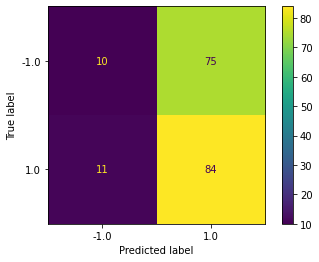

In [44]:
plot_confusion_matrix(clf, X_test_pca, y_test_bin)

In [45]:
y_pred = clf.predict(X_test_pca)

In [46]:
print('F1 score: '+str(f1_score(y_test_bin, y_pred, average='binary')))

F1 score: 0.6614173228346457


In [48]:
np.unique(y_test_bin, return_counts=True)

(array([-1.,  1.]), array([85, 95], dtype=int64))

# Try XGBoost

In [25]:
import xgboost as xgb

In [26]:
y_train_bin_xg = Binarizer().fit_transform(y_train)
y_test_bin_xg = Binarizer().fit_transform(y_test)
dtrain = xgb.DMatrix(X_train_pca, label=y_train_bin_xg)
dtest = xgb.DMatrix(X_test_pca, label=y_test_bin_xg)

In [27]:
param = {'max_depth':100, 'eta':1, 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'
evallist = [(dtest,'eval'),(dtrain,'train')]
num_round = 20

In [28]:
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.54502	train-auc:0.98982
[1]	eval-auc:0.52291	train-auc:0.99991
[2]	eval-auc:0.53430	train-auc:1.00000
[3]	eval-auc:0.52929	train-auc:1.00000
[4]	eval-auc:0.53858	train-auc:1.00000
[5]	eval-auc:0.53907	train-auc:1.00000
[6]	eval-auc:0.54229	train-auc:1.00000
[7]	eval-auc:0.55108	train-auc:1.00000
[8]	eval-auc:0.54266	train-auc:1.00000
[9]	eval-auc:0.54502	train-auc:1.00000
[10]	eval-auc:0.55951	train-auc:1.00000
[11]	eval-auc:0.56049	train-auc:1.00000
[12]	eval-auc:0.55294	train-auc:1.00000
[13]	eval-auc:0.55567	train-auc:1.00000
[14]	eval-auc:0.55022	train-auc:1.00000
[15]	eval-auc:0.54836	train-auc:1.00000
[16]	eval-auc:0.55170	train-auc:1.00000
[17]	eval-auc:0.54489	train-auc:1.00000
[18]	eval-auc:0.54328	train-auc:1.00000
[19]	eval-auc:0.54885	train-auc:1.00000


In [29]:
y_pred = bst.predict(xgb.DMatrix(X_test_pca))
y_pred_bin = y_pred>=0.5

In [35]:
print('F1 score: '+str(f1_score(y_test_bin_xg, y_pred_bin, average='binary')))

F1 score: 0.6442307692307693
